Loading processed/MoNA.parquet ...
✅ Loaded successfully. Shape: (9680, 23) (Rows, Columns)

--- 1. Data Type Check ---
Spectrum column type: <class 'numpy.ndarray'>
Spectrum array shape: (2001,)
Spectrum value range: Min=0.0000, Max=1.0000
✅ Normalization check: Passed (Max <= 1.0)

--- 2. Missing Value Check ---
✅ No missing values found.

--- 3. Flag Statistics (Top 10 cols) ---
Flag prevalence (Mean):
num_O           2.121901
has_C           0.999483
has_H           0.995455
has_single      0.993285
has_O           0.777479
has_double      0.694525
has_ring        0.691012
num_N           0.573864
has_aromatic    0.504029
has_carbonyl    0.497521
dtype: float64

--- 4. Visual Inspection (Random Sample) ---


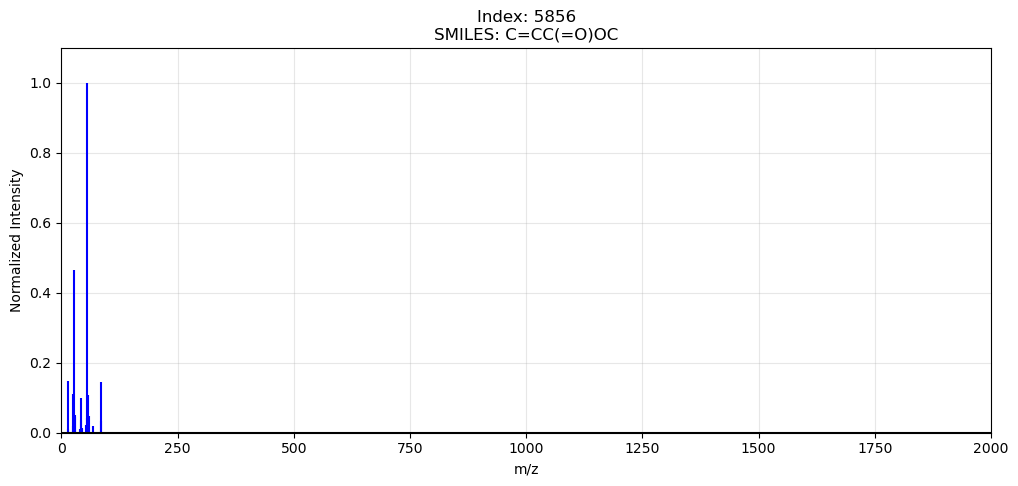

Displayed spectrum for Index 5856.
InChIKey: BAPJBEWLBFYGME-UHFFFAOYSA-N
Active Flags: ['num_O', 'has_C', 'has_O', 'has_H', 'has_single', 'has_double', 'has_ether', 'has_carbonyl'] ... (Total 8)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ノートブック内でのプロット表示用
%matplotlib inline

# ファイルパス (作成したファイル名に合わせてください)
PARQUET_FILE = "processed/MoNA.parquet"

def inspect_parquet_data(file_path):
    print(f"Loading {file_path} ...")
    
    # 1. 読み込み
    try:
        df = pd.read_parquet(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    print(f"✅ Loaded successfully. Shape: {df.shape} (Rows, Columns)")
    
    # 2. データ型の確認 (特にspectrum列)
    print("\n--- 1. Data Type Check ---")
    if 'spectrum' in df.columns:
        sample_spec = df.iloc[0]['spectrum']
        print(f"Spectrum column type: {type(sample_spec)}")
        
        if isinstance(sample_spec, np.ndarray):
            print(f"Spectrum array shape: {sample_spec.shape}")
            print(f"Spectrum value range: Min={sample_spec.min():.4f}, Max={sample_spec.max():.4f}")
            if sample_spec.max() <= 1.0:
                print("✅ Normalization check: Passed (Max <= 1.0)")
            else:
                print("⚠️ Warning: Spectrum values exceed 1.0")
        else:
            print("❌ Error: Spectrum is not a numpy array (probably loaded as list or string?)")
    else:
        print("❌ Error: 'spectrum' column not found.")

    # 3. 欠損値の確認
    print("\n--- 2. Missing Value Check ---")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("✅ No missing values found.")
    else:
        print("⚠️ Missing values detected:")
        print(null_counts[null_counts > 0])

    # 4. フラグ情報の統計 (すべて0になっていないか確認)
    print("\n--- 3. Flag Statistics (Top 10 cols) ---")
    # 'num_' または 'has_' で始まる列を抽出
    flag_cols = [c for c in df.columns if c.startswith('num_') or c.startswith('has_')]
    
    if flag_cols:
        # 平均値 (=発生率) を表示
        stats = df[flag_cols].mean().sort_values(ascending=False).head(10)
        print("Flag prevalence (Mean):")
        print(stats)
        
        # 全て0の列がないかチェック
        zero_cols = [c for c in flag_cols if df[c].sum() == 0]
        if zero_cols:
            print(f"\n⚠️ Note: The following columns are all zeros: {zero_cols}")
    else:
        print("No flag columns found.")

    # 5. スペクトルの可視化
    print("\n--- 4. Visual Inspection (Random Sample) ---")
    idx = random.randint(0, len(df) - 1)
    row = df.iloc[idx]
    
    smiles = row['smiles']
    spec = row['spectrum']
    
    # m/z軸の作成 (配列のインデックスそのもの)
    mz_axis = np.arange(len(spec))
    
    plt.figure(figsize=(12, 5))
    
    # ステムプロット (MSの表示に適しています)
    # マーカーを消して線だけにする ('markerfmt=" "')
    plt.stem(mz_axis, spec, markerfmt=" ", basefmt="k-", linefmt='b-')
    
    plt.title(f"Index: {idx}\nSMILES: {smiles}")
    plt.xlabel("m/z")
    plt.ylabel("Normalized Intensity")
    plt.xlim(0, len(spec)) # 全範囲表示
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Displayed spectrum for Index {idx}.")
    print(f"InChIKey: {row.get('inchikey', 'N/A')}")
    # フラグの一部を表示
    active_flags = [c for c in flag_cols if row[c] > 0]
    print(f"Active Flags: {active_flags[:10]} ... (Total {len(active_flags)})")

# 実行
inspect_parquet_data(PARQUET_FILE)